In [1]:
import sys
import os
from sklearn.feature_extraction import DictVectorizer
import time
from keras import models, layers
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import load_model
import math
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Bidirectional, SimpleRNN, Dense

Using TensorFlow backend.


In [2]:
OPTIMIZER = 'rmsprop'
BATCH_SIZE = 128
EPOCHS = 2
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 150
LSTM_UNITS = 512

### Word Embeddings
 - We replace the one-hot vectors with embeddings.  
 - Word embeddings are dense vectors obtained by a principal component
analysis or another method.  
 - They can be trained by the neural network or pretained.  
   Here, we will use pretrained embeddings from the GloVe project.  
   Our version of GloVe is lowercased, so set all the characters in lower case.  
 - We will add an Embedding layer at the start of the network
   We will initialize it with GloVe and make it trainable.

In [3]:
def load(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    file = file
    embeddings = {}
    glove = open(file)
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    embeddings_dict = embeddings
    embedded_words = sorted(list(embeddings_dict.keys()))
    return embeddings_dict

In [4]:
embedding_file = '/Users/erik/Dropbox/Public/Akademiskt/Year5/MachineLearning/Lab4/glove.6B.100d.txt'
embeddings_dict = load(embedding_file)

In [5]:
print(len(embeddings_dict['the']))
embeddings_dict['the']

100


array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [6]:
import re
class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

### CoNLL 2003 - File Structure

| Words    | POS | Groups | Named entities |
|----------|-----|--------|----------------|
| UN       | NNP | I-NP   | I-ORG          |
| official | NN  | I-NP   | O              |

_Note:  
Group detection is also called "chunking"._

#### Types of named entities:
  - persons
  - locations
  - organizations
  - names of miscellaneous entities

In [7]:
BASE_DIR = '/Users/erik/Dropbox/Public/Akademiskt/Year5/MachineLearning/Lab4/'

def load_conll2003_en():
    train_file = BASE_DIR + 'train.txt'
    dev_file = BASE_DIR + 'valid.txt'
    test_file = BASE_DIR + 'test.txt'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names


if __name__ == '__main__':
    train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()

    conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
    train_dict = conll_dict.transform(train_sentences)
    print(train_dict[0])
    print(train_dict[1])

train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
#train_sentences, dev_sentences, test_sentences, column_names = load_ud_en_ewt()
train_sentences[:100]

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]


'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto T'

In [8]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)
print('First sentences, train:\n')
train_dict[0:4]

First sentences, train:



[[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}],
 [{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'},
  {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'},
  {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'},
  {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
  {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'},
  {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'},
  {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'},
  {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
  {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}],
 [{'form': 'Peter', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-PER'},
  {'form': 'Blackburn', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'I-PER'}],
 [{'form': 'BRUSSELS', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-LOC'},
  {'form': '1996-08-22', 'ppos': 'CD', 'pchunk': 'I-NP', 'ner': 'O'}]]

Note that this is a list of *lists containing maps*.
  - The map is one word with its tags.
  - The *inner lists are sentences*, i.e. a collection of words.
  - Finally, we have an outer list since we have a whole bunch of sentences.

### Reading the Corpus and Building Indices
You will read the corpus with programs available from https://github.com/pnugues/edan95. These programs will enable you to load the files in the form of a list of dictionaries.

  1. Write a function that for each sentence returns the $\mathbf{X}$  and $\mathbf{Y}$ lists of symbols consisting of _words_ and _NER tags_.
  2. Create a vocabulary of all the words observed in the training set and the words in GloVe.
  2. Create indices and inverted indices for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

In [9]:
# 1. Write a function that for each sentence returns the X and Y lists of symbols consisting of words and NER tags.
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
    """Creates sequences from a list of dictionaries."""
    X = []
    Y = []
    for sentence in corpus_dict:
        x = []
        y = []
        for word in sentence:
            x += [word[key_x]]
            y += [word[key_y]]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

X_train_cat, Y_train_cat = build_sequences(train_dict)

In [10]:
# First sentences, X:words
X_train_cat[0:4]

[['-docstart-'],
 ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['peter', 'blackburn'],
 ['brussels', '1996-08-22']]

In [11]:
# With corresponding tags, Y:POS
Y_train_cat[0:4]

[['O'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['B-LOC', 'O']]

In [13]:
# 2. Create a vocabulary of all the words observed in the training set and the words in GloVe.
vocabulary_words = sorted(list(
    set([word for sentence 
         in X_train_cat for word in sentence])))
ner = sorted(list(set([ner for sentence 
                       in Y_train_cat for ner in sentence])))
NB_CLASSES = len(ner)

In [14]:
print("%s\nLength %d.\n" % (ner, len(ner)) )
print("%s\nLength %d." % (vocabulary_words[10000:10010] , len(vocabulary_words)) )


['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
Length 9.

['goinxha', 'golan', 'gold', 'golden', 'goldiman', 'goldiner', 'goldman', 'golds', 'goldsmith', 'goldstein']
Length 21010.


3. Create indices and inverted indices for the words and the NER.  
**You will associate each word with a number.**  
You will use index *0 for the padding symbol* and *1 for unknown words*.

In [15]:
# 3.
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary_words = sorted(list(set(vocabulary_words + 
                                   list(embeddings_words))))
cnt_uniq = len(vocabulary_words) + 2
print('Number of unique words in the vocabulary; embeddings and corpus:', 
      cnt_uniq)

Words in GloVe: 400000
Number of unique words in the vocabulary; embeddings and corpus: 402597


In [16]:
embeddings_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [17]:
# We start at one to make provision for the padding symbol 0 in RNN and LSTMs and 1 for the unknown words.
# This means we have to start enumeration from 2.
rev_word_idx = dict(enumerate(vocabulary_words, start=2))
rev_ner_idx = dict(enumerate(ner, start=2))

# Flip order of values and keys.
word_idx = {v: k for k, v in rev_word_idx.items()}
ner_idx = {v: k for k, v in rev_ner_idx.items()}

print('Word Index:\n', list(word_idx.items())[100000:100010])
print('\nNer Index:')

ner_idx

Word Index:
 [('chetwynd-talbot', 100002), ('cheuk', 100003), ('cheul', 100004), ('cheula', 100005), ('cheun', 100006), ('cheung', 100007), ('cheuse', 100008), ('cheuvreux', 100009), ('cheuvront', 100010), ('chev', 100011)]

Ner Index:


{'B-LOC': 2,
 'B-MISC': 3,
 'B-ORG': 4,
 'B-PER': 5,
 'I-LOC': 6,
 'I-MISC': 7,
 'I-ORG': 8,
 'I-PER': 9,
 'O': 10}

### Creating the X and Y Sequences
You will now create the input and output sequences with numerical indices

Convert the X and Y list of symbols in a list of numbers using the indices you created.
Pad the sentences using the pad_sequences function.
Do the same for the development set.

_Note_

`get(key[, default])`  
Return the value for key if key is in the dictionary, else default. If default is not given, it defaults to None, so that this method never raises a KeyError.


Also, the `map()` function executes a specified function for each item in a iterable. The item is sent to the function as a parameter.  
\> `map(function, iterables)`

In [18]:
def to_index(X, idx):
    """
    Convert the word/NER-tag lists to indexes.
    :param X: List of word/NER-tag lists
    :param idx: word to number dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = list(map(lambda x: idx.get(x, 1), x)) # So set to 1 (our unknown indicator) if not found in idx.
        X_idx += [x_idx]
    return X_idx

In [19]:
# We create the parallel sequences of indexes, i.e. sentences as indices.
X_idx = to_index(X_train_cat, word_idx)
Y_idx = to_index(Y_train_cat, ner_idx)

In [20]:
print('A sentence in X_idx: Word Indices.')
print(X_idx[2001])

print('A sentence in Y_idx: NER Indices.')
print(Y_idx[2001])

A sentence in X_idx: Word Indices.
[340921, 517, 73883, 15424]
A sentence in Y_idx: NER Indices.
[2, 10, 2, 10]


Note tags corresponding to words:  
`{'B-LOC': 2,
 'B-MISC': 3,
 'B-ORG': 4,
 'B-PER': 5,
 'I-LOC': 6,
 'I-MISC': 7,
 'I-ORG': 8,
 'I-PER': 9,
 'O': 10}`

*Remember: `from keras.preprocessing.sequence import pad_sequences`*  
https://keras.io/preprocessing/sequence/#pad_sequences

`keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)`

>Pads sequences to the same length.  

>This function transforms a list of `num_samples` sequences (*lists of integers*) into a 2D Numpy array of shape `(num_samples, num_timesteps)`. `num_timesteps` is either the `maxlen` argument if provided, *or the length of the longest sequence otherwise*.  
 Sequences that are shorter than `num_timesteps` are padded with `value` at the end.  
 Sequences longer than `num_timesteps` are truncated so that they fit the desired length. The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.  
 Pre-padding is the default.

In [21]:
# Since maxlen not provided, will pre-pad to length of longest sequence: 113 in this case.
X = pad_sequences(X_idx)
Y = pad_sequences(Y_idx)
print('Sentence above is padded into:\n')
print(X[2001])
print(Y[2001])

Sentence above is padded into:

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0 340921
    517  73883  15424]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0

Remember: `from keras.utils import to_categorical`  
https://keras.io/utils/#to_categorical

`keras.utils.to_categorical(y, num_classes=None, dtype='float32')`

> Converts a class vector (integers) to binary class matrix.  
  E.g. for use with categorical_crossentropy.

In [23]:
# Encode categories (integer) vector with a binary class matrix.
Y_train = to_categorical(Y, num_classes=len(ner) + 2) # The +2 is still a bit mysterious....

print("Example: second to last word in padded sentence above.")
print(Y_train[2001][-2])

print("\nExample: the whole padded sentence above.")
print(Y_train[2001])

print("\nTotal number of sentences: %d." % len(Y_train))
print("Padded sentence length is: %d." % len(Y_train[2001]))
print("Each word in sentence can be this number of categories: %d." % len(Y_train[2001][-2]))

Example: second to last word in padded sentence above.
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

Example: the whole padded sentence above.
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

Total number of sentences: 14987.
Padded sentence length is: 113.
Each word in sentence can be this number of categories: 11.


## Process validation input too

Since we use a validation (development) set, we need to preprocess it too.

In [25]:
# In X_dict, we replace the words with their index
X_val_cat, Y_val_cat = build_sequences(dev_dict)
# We create the parallel sequences of indexes
X_val_idx = to_index(X_val_cat, word_idx)
Y_val_idx = to_index(Y_val_cat, ner_idx)

X_val_padded = pad_sequences(X_val_idx)
Y_val_padded = pad_sequences(Y_val_idx)
print('Number of test sentences and tags: %d, %d.' % (len(X_val_padded), len(Y_val_padded)) )
print('Padded to length: %d.' % len(X_val_padded[2001]), '\n')

print('Example, sentence at index 2001:\n')
print('X: Words Indices\n', X_val_padded[2001])
print('\nY: Tag indices\n', Y_val_padded[2001])

# Encode categories (integer) vector with a binary class matrix.
# One extra symbol for 0 (padding).
Y_val_padded_vectorized = to_categorical(Y_val_padded, num_classes=len(ner) + 2)

print('\nExample tags with sentence above:')
print(Y_val_padded_vectorized[2001][-10:])

print('\nCheck shape consistency:')
print(X_val_padded.shape)
print(Y_val_padded_vectorized.shape)

Number of test sentences and tags: 3466, 3466.
Padded to length: 109. 

Example, sentence at index 2001:

X: Words Indices
 [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0  23815 312139  53251    159  64830    325      1]

Y: Tag indices
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

# Create the embedding matrix
1. Create a matrix whose size will be that of all the words: The unique words in the training set and the words in GloVe. Initialize it with random values.
2. Fill the matrix with the GloVe embeddings. You will use the indices from the previous section.

In [28]:
rdstate = np.random.RandomState(1234567)
embedding_matrix = rdstate.uniform(-0.05, 0.05, 
                                   (len(vocabulary_words) + 2, 
                                    EMBEDDING_DIM))
print(np.shape(embedding_matrix))

(402597, 100)


In [29]:
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value.
        embedding_matrix[word_idx[word]] = embeddings_dict[word]

In [30]:
print('Check with output below')
embeddings_dict['the'][0:20]

Check with output below


array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ], dtype=float32)

In [31]:
print('Shape of embedding matrix:', embedding_matrix.shape, '\n')

print('Embedding of word \"the\"\n', embedding_matrix[word_idx['the']], '\n')

print('Embedding of the padding symbol, idx 0, random numbers\n', embedding_matrix[0][0:5], '\n')

print('Embedding of unknown word, idx 1, random numbers\n', embedding_matrix[0][0:5])

Shape of embedding matrix: (402597, 100) 

Embedding of word "the"
 [-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
 -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
 -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
 -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
 -1.

# RNN

https://keras.io/layers/embeddings/

```
OPTIMIZER = 'rmsprop'
BATCH_SIZE = 128
EPOCHS = 2
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 150
LSTM_UNITS = 512
```

In [32]:
max_features = len(vocabulary_words) + 2

model = models.Sequential()
model.add(layers.Embedding(max_features,
                           EMBEDDING_DIM,
                           mask_zero=True,
                           input_length=None))
model.layers[0].set_weights([embedding_matrix])
# The default is True
model.layers[0].trainable = True
#model.add(SimpleRNN(100, return_sequences=True))
model.add(Bidirectional(SimpleRNN(100, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)))
#model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
#model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(NB_CLASSES + 2, activation='softmax'))

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         40200     
_________________________________________________________________
dense_1 (Dense)              (None, None, 11)          2211      
Total params: 40,302,111
Trainable params: 40,302,111
Non-trainable params: 0
_________________________________________________________________


In [34]:
n_epochs = 30
history = model.fit(X, Y_train, epochs=n_epochs, batch_size=BATCH_SIZE, 
                    validation_data=(X_val_padded, Y_val_padded_vectorized))

Train on 14987 samples, validate on 3466 samples
Epoch 1/30
14987/14987 [==============================] - 68s 5ms/step - loss: 0.5076 - acc: 0.8649 - val_loss: 0.3024 - val_acc: 0.9154
Epoch 2/30
14987/14987 [==============================] - 65s 4ms/step - loss: 0.2702 - acc: 0.9232 - val_loss: 0.1953 - val_acc: 0.9474
Epoch 3/30
14987/14987 [==============================] - 65s 4ms/step - loss: 0.2180 - acc: 0.9371 - val_loss: 0.1725 - val_acc: 0.9544
Epoch 4/30
14987/14987 [==============================] - 67s 4ms/step - loss: 0.1864 - acc: 0.9464 - val_loss: 0.1516 - val_acc: 0.9601
Epoch 5/30
14987/14987 [==============================] - 67s 4ms/step - loss: 0.1660 - acc: 0.9518 - val_loss: 0.1428 - val_acc: 0.9621
Epoch 6/30
14987/14987 [==============================] - 67s 4ms/step - loss: 0.1504 - acc: 0.9559 - val_loss: 0.1372 - val_acc: 0.9638
Epoch 7/30
14987/14987 [==============================] - 67s 4ms/step - loss: 0.1384 - acc: 0.9591 - val_loss: 0.1328 - val_acc:

In [39]:
#model.save('simpleRNN_6e.h5')

Plot results on validation set. 

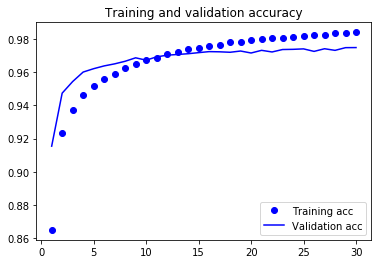

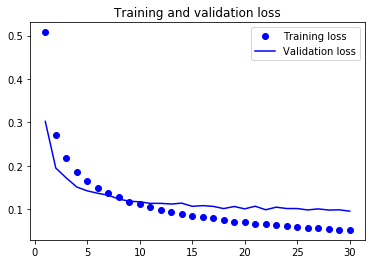

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,n_epochs+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## RNN Evaluation

### Rehsape test input data
Need to do the whole input formatting procedure for the **test set** too.

So just repeat what we did above but with the test set as input.

In [37]:
# In X_dict, we replace the words with their index
X_test_cat, Y_test_cat = build_sequences(test_dict)
# We create the parallel sequences of indexes
X_test_idx = to_index(X_test_cat, word_idx)
Y_test_idx = to_index(Y_test_cat, ner_idx)

X_test_padded = pad_sequences(X_test_idx)
Y_test_padded = pad_sequences(Y_test_idx)
print('Number of test sentences and tags: %d, %d.' % (len(X_test_padded), len(Y_test_padded)) )
print('Padded to length: %d.' % len(X_test_padded[2001]), '\n')

print('Example, sentence at index 2001:\n')
print('X: Words Indices\n', X_test_padded[2001])
print('\nY: Tag indices\n', Y_test_padded[2001])

# Encode categories (integer) vector with a binary class matrix.
# One extra symbol for 0 (padding).
Y_test_padded_vectorized = to_categorical(Y_test_padded,num_classes=len(ner) + 2)

print('\nExample tags with sentence above:')
print(Y_test_padded_vectorized[2001][-15:-10])

print('\nCheck shape consistency:')
print(X_test_padded.shape)
print(Y_test_padded_vectorized.shape)

Number of test sentences and tags: 3684, 3684.
Padded to length: 124. 

Example, sentence at index 2001:

X: Words Indices
 [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0 359698 195584 375978
 184172 327134  87571 107473 175799 108345 195756 143910 270183 195625
    154  15453  87571    517  56102 195553 390246  59334 359698 241243
 270361  89620 321432   

### Evaluate and predict on test set

In [38]:
test_loss, test_acc = model.evaluate(X_test_padded, 
                                     Y_test_padded_vectorized)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

3684/3684 [==============================] - 3s 903us/step
Loss: 0.14943445232331784
Accuracy: 0.960675511440418


In [39]:
print('X_test_padded', X_test_padded[2001])
print('Y_test_padded', Y_test_padded[2001])

X_test_padded [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0 359698 195584 375978
 184172 327134  87571 107473 175799 108345 195756 143910 270183 195625
    154  15453  87571    517  56102 195553 390246  59334 359698 241243
 270361  89620 321432    936]
Y_test_padded [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  

In [40]:
ner_predictions = model.predict(X_test_padded, verbose=1)

3684/3684 [==============================] - 3s 923us/step


In [41]:
print(ner_predictions[2001][-15])
print('Length: %d.' % len(ner_predictions[2001]))

print('\nSo output is still padded:')
print(ner_predictions.shape)

[5.3607002e-12 6.5027372e-12 9.9939620e-01 5.7736670e-05 2.3895378e-04
 2.3150909e-05 1.4147745e-04 4.0447680e-06 1.0677781e-04 1.5955050e-06
 2.9958817e-05]
Length: 124.

So output is still padded:
(3684, 124, 11)


### Remove padding

In [42]:
ner_pred_num = []
for pred_nbr, ner_preds in enumerate(ner_predictions):
    # len(X_test_cat[pred_nbr]) is the length a sentence number pred_nbr.
    # Since we used pre-paddding, extract tag predictions from -sentence_length to end.
    ner_pred_num += [ ner_preds[ -len(X_test_cat[pred_nbr]) : ] ]

print('Check with above:')
print(ner_pred_num[2001][-15])
print('Length: %d. So padding removed.' % len(ner_pred_num[2001]))

Check with above:
[5.3607002e-12 6.5027372e-12 9.9939620e-01 5.7736670e-05 2.3895378e-04
 2.3150909e-05 1.4147745e-04 4.0447680e-06 1.0677781e-04 1.5955050e-06
 2.9958817e-05]
Length: 27. So padding removed.


### From logistic regression to one tag
We still have our results in probabilistic form from the softmax output.  
Take the maximum to get the tag predicted as most likely.

Note: `argmax` returns the **indices** of the maximum values along an axis.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html

In [44]:
# Remember
print(rev_ner_idx)

{2: 'B-LOC', 3: 'B-MISC', 4: 'B-ORG', 5: 'B-PER', 6: 'I-LOC', 7: 'I-MISC', 8: 'I-ORG', 9: 'I-PER', 10: 'O'}


In [45]:
ner_pred = []
for sentence in ner_pred_num:
    ner_pred_idx = list(map(np.argmax, sentence)) # Predicted indices for this sentence.
    ner_pred_cat = list(map(rev_ner_idx.get, ner_pred_idx)) # Convert indices to 'I-ORG' and so on for this sentence.
    ner_pred += [ner_pred_cat]

print('Length consistency check: %d, %d.\n' % (len(ner_pred), len(Y_test_cat)) )
print('Example for sentence in index 2001:')
print('\nPredicted:\n', ner_pred[2001])
print('\nCorrect answer:\n', Y_test_cat[2001])

Length consistency check: 3684, 3684.

Example for sentence in index 2001:

Predicted:
 ['O', 'B-MISC', 'O', 'B-ORG', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Correct answer:
 ['O', 'B-MISC', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [46]:
# Check accuracy separately for words in and not in dictionary.
total, correct, total_ukn, correct_ukn = 0, 0, 0, 0
for id_s, sentence in enumerate(X_test_cat):
    for id_w, word in enumerate(sentence):
        total += 1
        if ner_pred[id_s][id_w] == Y_test_cat[id_s][id_w]:
            correct += 1
        # The word is not in the dictionary
        if word not in word_idx:
            total_ukn += 1
            if ner_pred[id_s][id_w] == Y_test_cat[id_s][id_w]:
                correct_ukn += 1

print('total %d, correct %d, accuracy %f' % 
      (total, correct, correct / total))
if total_ukn != 0:
    print('total unknown %d, correct %d, accuracy %f' % 
          (total_ukn, correct_ukn, correct_ukn / total_ukn))



total 46666, correct 44898, accuracy 0.962114
total unknown 1143, correct 960, accuracy 0.839895


### Add predictions to file for evaluation script

In [47]:
def add_ner_predictions(input_filepath, pred_sentence_list, output_filepath):
    """Add the NER predictions as a fifth column in test.txt."""
    with open(input_filepath, 'r') as readf, open(output_filepath, 'w') as writef:
        sentence_idx, word_idx = 0, 0
        for line in readf:
            # If line was empty, next sentence.
            if not line.strip():
                writef.write('\n')
                sentence_idx += 1
                word_idx = 0
            else:
                writef.write(line.rstrip() + ' ' + ner_pred[sentence_idx][word_idx] + '\n')
                word_idx += 1

In [48]:
add_ner_predictions('test_copy.txt', ner_pred, 'test_result.txt')

In [374]:
# perl conlleval.pl < test_result.txt